In [1]:
import sys
import numpy as np
import cv2
from IPython.display import Image, display
from ipywidgets import widgets
%matplotlib inline
from matplotlib import pyplot as plt

print("python version:", sys.version)
print("numpy version:", np.__version__)
print("opencv version:", cv2.__version__) # type: ignore

python version: 3.10.6 (main, May 29 2023, 11:10:38) [GCC 11.3.0]
numpy version: 1.25.0
opencv version: 4.8.0


In [2]:
def imshow(img):
    """ndarray 配列をインラインで Notebook 上に表示する。
    """
    ret, encoded = cv2.imencode(".jpg", img)
    display(Image(encoded))

def houghline(img, rho, theta, threshold, min_line_len, max_line_gap):
    """ハフ変換で直線検出を行い、結果を表示する。
    """
    # グレースケールに変換する。
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Canny 法で2値化する。
    edges = cv2.Canny(gray, 150, 300, L2gradient=True)
    # ハフ変換で直線検出する。
    lines = cv2.HoughLinesP(
        edges,
        rho,
        np.radians(theta),
        threshold,
        minLineLength=min_line_len,
        maxLineGap=max_line_gap,
    )
    # 検出した直線を描画する。
    dst = img.copy()

    if lines is not None:
        for x1, y1, x2, y2 in lines.squeeze(axis=1):
            cv2.line(dst, (x1, y1), (x2, y2), (0, 0, 255), 2)
    imshow(dst)

In [3]:
def slopeComp(img:np.ndarray, slope:float, axis:int, scale:float=1.0)->np.ndarray:
    x = np.arange(img.shape[axis]).astype(np.float32)
    y = x*slope
    if axis == 0:
        base = y.reshape((-1,1)).repeat(img.shape[1], axis=1)
    elif axis == 1:
        base = y.reshape((1,-1)).repeat(img.shape[0], axis=0)
    else:
        raise ValueError("invalid axis")
    ret = ((img.astype(np.float32) - base) * scale).astype(np.uint8)
    return ret

def makeSobelFilter(size:int)->np.ndarray:
    halfsize = (size - 1) // 2
    return np.hstack([np.full(halfsize, -1), [0], np.full(halfsize, 1)]).reshape((1,-1)).repeat(size, axis=0)

def broadD(img, m_size, s_size, axis=0)->np.ndarray:
    ret = cv2.medianBlur(img, m_size)
    kernel = makeSobelFilter(s_size) if axis == 0 else makeSobelFilter(s_size).T
    ret = cv2.filter2D(ret, -1, kernel)
    return ret

def broadGrad(img, m_size, s_size)->np.ndarray:
    dx = broadD(img, m_size, s_size, axis=0).astype(np.uint32)
    dy = broadD(img, m_size, s_size, axis=1).astype(np.uint32)
    return np.sqrt(dx**2 + dy**2).astype(np.uint8)

def binarize(img, threshold):
    bool_img = img > threshold
    return np.full(img.shape, 255, dtype=np.uint8) * bool_img

def drawInSubplot(fig, pos, img, title="", colorbar=False):
    ax = fig.add_subplot(*pos)
    axImage = ax.imshow(img)
    if title:
        ax.set_title(title)
    if colorbar:
        fig.colorbar(ax.imshow(img), ax=ax)
    return ax,axImage

def detectStep(raw, gray, bin_thresh, rho, theta, vote_thresh, min_len, max_gap):
    edges = binarize(gray, bin_thresh)
    # ハフ変換で直線検出する。
    lines = cv2.HoughLinesP(
        edges,
        rho,
        np.radians(theta),
        vote_thresh,
        minLineLength=min_len,
        maxLineGap=max_gap,
    )
    # 検出した直線を描画する。
    dst = cv2.applyColorMap(raw, cv2.COLORMAP_WINTER)

    if lines is not None:
        for x1, y1, x2, y2 in lines.squeeze(axis=1):
            cv2.line(dst, (x1, y1), (x2, y2), (0, 0, 255), 2)
    imshow(dst)

(2560, 2560) uint8
(981, 983, 3) uint8


/tmp/ipykernel_21481/3319538508.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


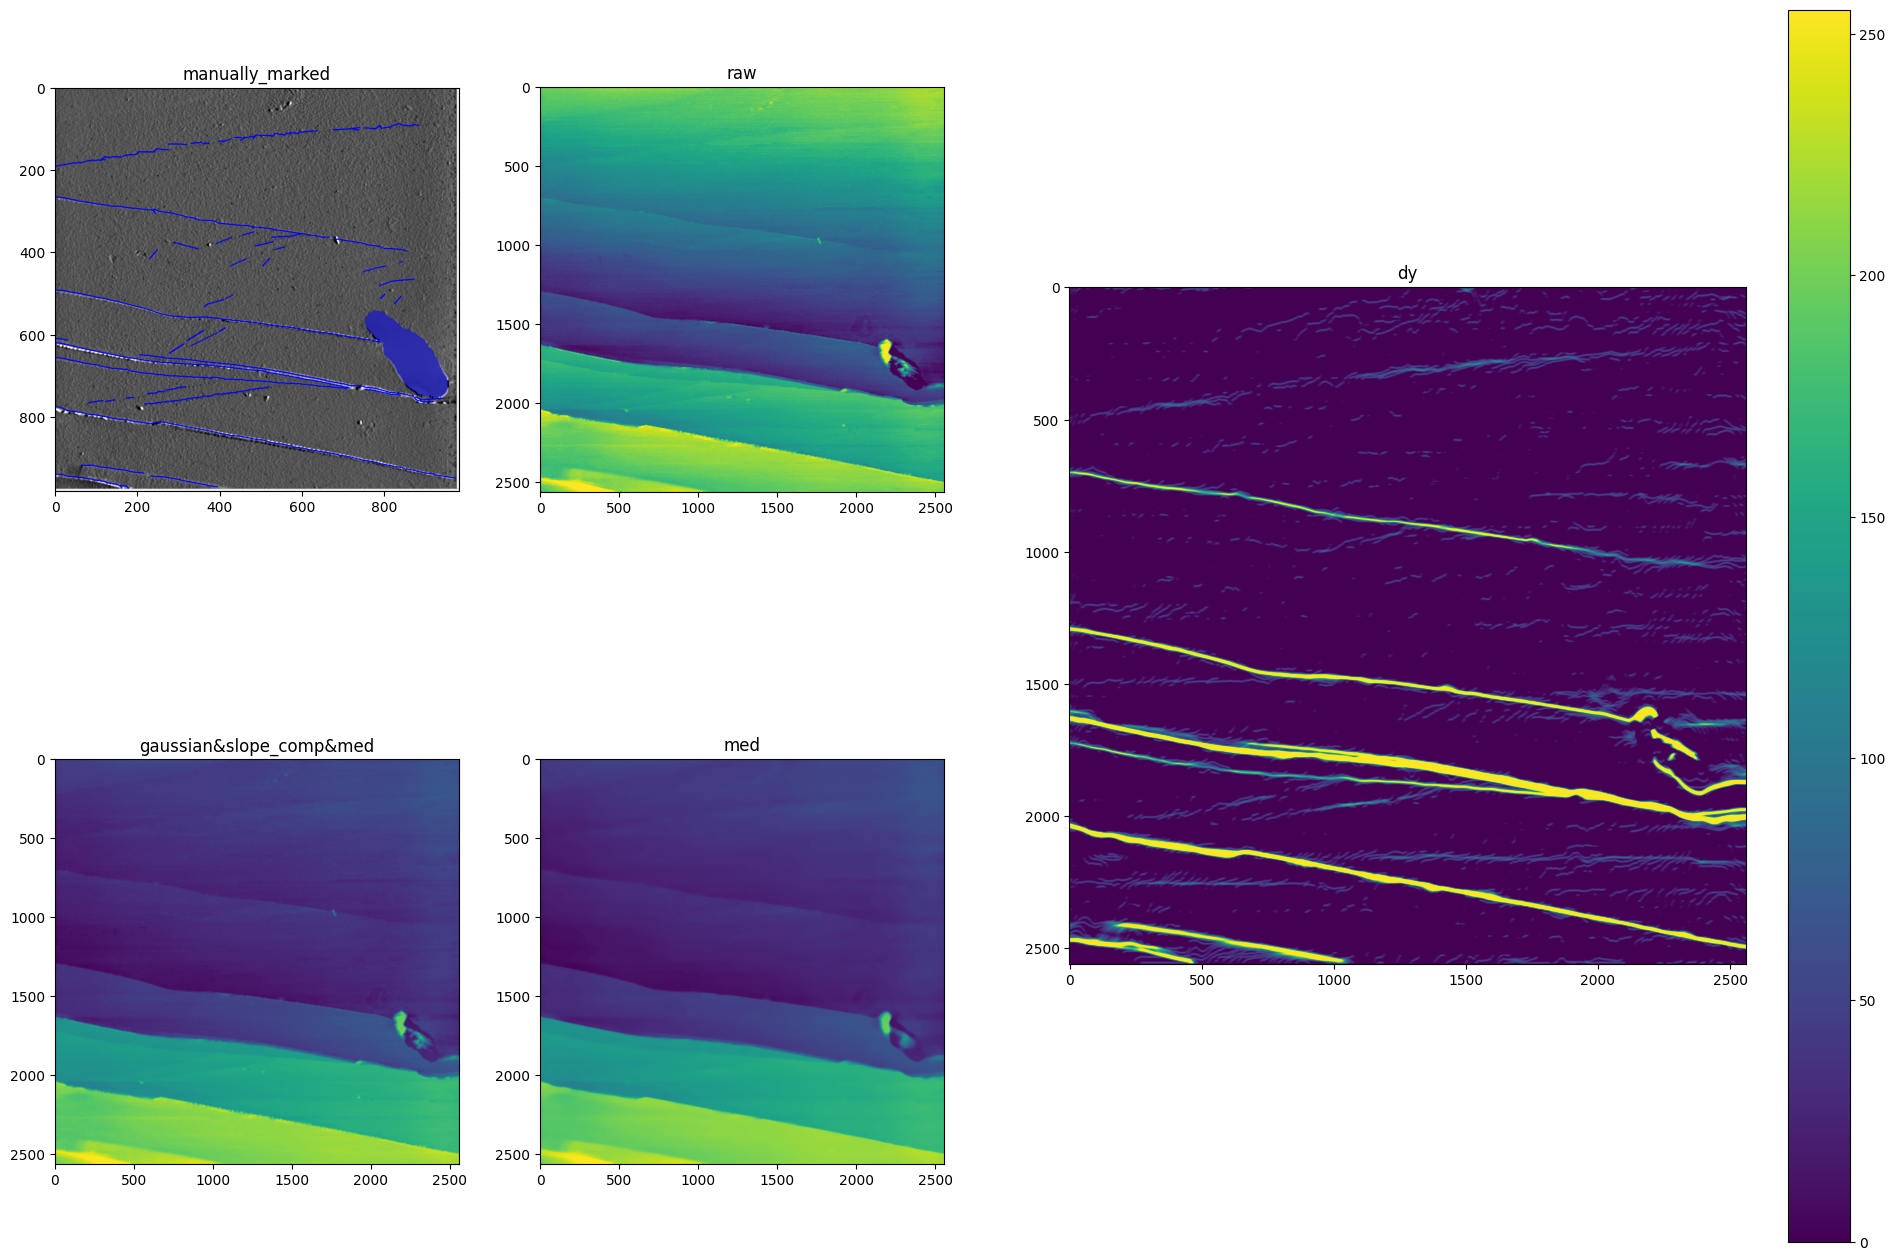

In [4]:
raw_data1 = cv2.cvtColor(cv2.imread("data/data1/rawdata1.jpg"), cv2.COLOR_BGR2GRAY)
print(raw_data1.shape, raw_data1.dtype)
manually_marked = cv2.imread("data/data1/rawdata1_manually_marked.png")
print(manually_marked.shape, manually_marked.dtype)

data = cv2.GaussianBlur(raw_data1, (1,11), 11)
data = slopeComp(data, -46/500, 0, 0.5)
m_size, s_size = 41, 11
med = cv2.medianBlur(data, m_size)

dy = broadD(data, m_size, s_size, axis=1)
binarized = binarize(dy, 20)

linedetect = cv2.HoughLinesP(binarized, 1, np.pi/180, 100, 0, 0)

fig = plt.figure(figsize=(24, 16))
drawInSubplot(fig, (2, 4, 1), manually_marked, "manually_marked")
drawInSubplot(fig, (2, 4, 2), raw_data1, "raw")
drawInSubplot(fig, (2, 4, 5), data, "gaussian&slope_comp&med")
drawInSubplot(fig, (2, 4, 6), med, "med")
drawInSubplot(fig, (1, 2, 2), dy, "dy", True)
# drawInSubplot(fig, (2, 4, 6), binarized, "binarized")

# ax7 = fig.add_subplot(2, 2, 4)
# ax7.plot(raw_data1[:,1000], label="raw")
# ax7.plot(data[:,1000], label="slope_comp")
# ax7.plot(med[:,1000], label="med", color=(0, 1, 0, 0.5))
# ax7.plot(dy[:,1000], label="dy", color=(0, 0, 1, 0.5))
# ax7.plot(binarized[:,1000], label="binarized", color=(1, 0, 0, 0.5))
# ax7.legend()

fig.show()

In [144]:
slider_width = "600px"
# bin_thresh
bin_thresh_slider = widgets.IntSlider(min=1, max=255, step=1, value=1, description="bin_thresh: ")
bin_thresh_slider.layout.width = slider_width
# rho
rho_slider = widgets.IntSlider(min=1, max=10, step=1, value=1, description="rho: ")
rho_slider.layout.width = slider_width
# theta
theta_slider = widgets.IntSlider(min=1, max=180, step=1, value=1, description="theta: ")
theta_slider.layout.width = slider_width
# vote_thresh
vote_thresh_slider = widgets.IntSlider(
    min=0, max=500, step=1, value=100, description="threshold: "
)
vote_thresh_slider.layout.width = slider_width
# min_len
min_len_slider = widgets.IntSlider(
    min=0, max=500, step=1, value=0, description="minLineLength: "
)
min_len_slider.layout.width = slider_width
# max_gap
max_gap_slider = widgets.IntSlider(
    min=0, max=500, step=1, value=50, description="maxLineGap: "
)
max_gap_slider.layout.width = slider_width

# 画像を読み込む。
img = cv2.resize(dy, (640,640))
raw = cv2.resize(raw_data1, (640,640))

# ウィジェットを表示する。
widgets.interactive(
    detectStep,
    raw = widgets.fixed(raw),
    gray=widgets.fixed(img),
    bin_thresh=bin_thresh_slider,
    rho=rho_slider,
    theta=theta_slider,
    vote_thresh=vote_thresh_slider,
    min_len=min_len_slider,
    max_gap=max_gap_slider,
)

interactive(children=(IntSlider(value=1, description='bin_thresh: ', layout=Layout(width='600px'), max=255, mi…